In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # Para preprocess_colors
import warnings

warnings.filterwarnings('ignore')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
IMG_SIZE = 256

# --- 1. DogColorizationDataset (Corrigido para não mover para DEVICE) ---
class DogColorizationDataset(Dataset):
    def __init__(self, root_dir):
        self.root = root_dir
        try:
            # Modificado para incluir .jpg, .png, .jpeg independentemente do caso
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if not self.image_paths:
                print(f"Aviso: Nenhum arquivo de imagem encontrado em {root_dir} com as extensões .jpg, .png, .jpeg. O dataset estará vazio.")
        except FileNotFoundError:
            print(f"Erro: Diretório do dataset não encontrado: {root_dir}. O dataset estará vazio.")
            self.image_paths = []

        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            rgb_img = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception as e:
            print(f"Erro ao carregar imagem {self.image_paths[idx]}: {e}. Retornando tensor placeholder na CPU.")
            L_placeholder = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            ab_placeholder = torch.zeros((2, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            # REMOVIDO .to(DEVICE) daqui
            return L_placeholder, ab_placeholder

        rgb_img_transformed = self.transform(rgb_img)
        lab_img = color.rgb2lab(np.array(rgb_img_transformed)).astype(np.float32)
        L = lab_img[:,:,0] / 50.0 - 1.0
        ab = lab_img[:,:,1:] / 128.0

        # REMOVIDO .to(DEVICE) daqui. Os tensores serão criados na CPU.
        return (
            torch.FloatTensor(L).unsqueeze(0),
            torch.FloatTensor(ab).permute(2,0,1)
        )

# --- 2. preprocess_colors (Ajustado para a nova __getitem__) ---
def preprocess_colors(data_train_path='data/train', force_recompute=False):
    os.makedirs('data', exist_ok=True)
    ab_bins_path = 'data/ab_bins.npy'
    color_weights_path = 'data/color_weights.pt'

    if not force_recompute and os.path.exists(ab_bins_path) and os.path.exists(color_weights_path):
        print("Arquivos ab_bins.npy e color_weights.pt já existem. Pulando pré-processamento.")
        return

    print("Iniciando pré-processamento de cores...")
    grid_step = 10
    min_ab, max_ab = -110, 110
    axis_values = np.arange(min_ab, max_ab + grid_step, grid_step)
    ab_candidate_bins_x, ab_candidate_bins_y = np.meshgrid(axis_values, axis_values)
    ab_candidate_bins = np.stack((ab_candidate_bins_x.flatten(), ab_candidate_bins_y.flatten()), axis=-1).astype(np.float32)

    valid_bins_list = []
    for a_val, b_val in ab_candidate_bins:
        lab_pixel = np.array([[[50.0, a_val, b_val]]], dtype=np.float32)
        try:
            rgb_pixel = color.lab2rgb(lab_pixel)
            if np.all(rgb_pixel >= 0) and np.all(rgb_pixel <= 1):
                valid_bins_list.append([a_val, b_val])
        except Exception:
            pass

    ab_bins_final = np.array(valid_bins_list, dtype=np.float32)
    if len(ab_bins_final) == 0:
        raise ValueError("Nenhum bin 'ab' válido encontrado. Verifique os parâmetros de quantização.")
    np.save(ab_bins_path, ab_bins_final)
    current_Q = len(ab_bins_final)
    print(f"Salvo {ab_bins_path} com Q = {current_Q} bins. (O artigo menciona Q=313)")

    print(f"Calculando distribuição de pesos de cor a partir de '{data_train_path}'...")
    dataset_for_hist_calc = DogColorizationDataset(data_train_path)

    if len(dataset_for_hist_calc) == 0:
        print("Aviso: Dataset de treinamento para histograma está vazio. Gerando pesos uniformes.")
        p_smooth = np.ones(current_Q, dtype=np.float32) / max(1, current_Q) # Evita divisão por zero se current_Q for 0
    else:
        hist = np.zeros(current_Q, dtype=np.int64)
        num_processed_pixels = 0

        for i, (L_channel_sample, ab_channels_sample_normalized) in enumerate(dataset_for_hist_calc):
            # ab_channels_sample_normalized agora está na CPU.
            # A verificação do placeholder também usará tensores na CPU.
            placeholder_for_comparison_cpu = torch.zeros((2, IMG_SIZE, IMG_SIZE), dtype=torch.float32) # Criado na CPU

            if ab_channels_sample_normalized.numel() == 0 or \
               (IMG_SIZE > 0 and torch.equal(ab_channels_sample_normalized, placeholder_for_comparison_cpu)):
                if ab_channels_sample_normalized.numel() > 0 :
                     print(f"  Aviso: Pulando amostra placeholder {i+1}/{len(dataset_for_hist_calc)} (provavelmente erro de carregamento de imagem).")
                continue
            
            # .cpu() aqui é redundante se já estiver na CPU, mas não prejudica.
            single_sample_ab_denormalized_np = ab_channels_sample_normalized.cpu().numpy() * 128.0
            single_sample_ab_transposed_np = single_sample_ab_denormalized_np.transpose(1, 2, 0)
            pixels_ab_pairs = single_sample_ab_transposed_np.reshape(-1, 2)
            num_processed_pixels += pixels_ab_pairs.shape[0]

            if pixels_ab_pairs.shape[0] > 0:
                distances_to_bins = cdist(pixels_ab_pairs, ab_bins_final, metric='euclidean')
                nearest_bin_indices = np.argmin(distances_to_bins, axis=1)
                hist += np.bincount(nearest_bin_indices, minlength=current_Q)
            
            if (i + 1) % 10 == 0 or (i+1) == len(dataset_for_hist_calc):
                print(f"  Processada imagem {i+1}/{len(dataset_for_hist_calc)} para histograma.")

        if num_processed_pixels == 0 or hist.sum() == 0:
            print("Aviso: Nenhum pixel processado ou histograma de cores vazio. Usando pesos uniformes.")
            p_smooth = np.ones(current_Q, dtype=np.float32) / max(1, current_Q)
        else:
            p_empirical = hist.astype(np.float32) / hist.sum()
            sigma_smooth = 5.0
            p_smooth = np.zeros_like(p_empirical, dtype=np.float32)
            for q_idx in range(current_Q):
                distances_from_q = np.linalg.norm(ab_bins_final - ab_bins_final[q_idx], axis=1)
                gaussian_kernel_values = np.exp(-distances_from_q**2 / (2 * sigma_smooth**2))
                p_smooth[q_idx] = np.sum(p_empirical * gaussian_kernel_values)

            if p_smooth.sum() < 1e-9:
                 print("Aviso: Distribuição de probabilidade suavizada (p_smooth) é zero. Usando pesos uniformes.")
                 p_smooth = np.ones(current_Q, dtype=np.float32) / max(1, current_Q)
            else:
                p_smooth = p_smooth / p_smooth.sum()

    lambda_rebalance = 0.5
    denominator = (1 - lambda_rebalance) * p_smooth + (lambda_rebalance / max(1, current_Q))
    weights = 1.0 / np.maximum(denominator, 1e-9)
    expected_w = np.sum(p_smooth * weights)
    if abs(expected_w) < 1e-9:
        print("Aviso: E[w] é próximo de zero. Pesos podem não estar normalizados corretamente.")
    else:
        weights = weights / expected_w

    torch.save(torch.FloatTensor(weights), color_weights_path)
    print(f"Salvo {color_weights_path}.")
    print("Pré-processamento de cores concluído.")

# --- O restante do seu código (ColorNet, ColorLoss, train, colorize, if __name__ == '__main__') ---
# Lembre-se que a função train() já move os batches para DEVICE:
# L_channel_batch = L_channel_batch.to(DEVICE)
# ab_channels_batch = ab_channels_batch.to(DEVICE)
# Isso agora é necessário e correto, pois o Dataset retorna tensores na CPU.

# ... (cole o restante do seu código aqui, começando por ColorNet)
# Exemplo de como ficaria a ColorLoss (apenas o início, para mostrar que não muda devido a esta correção específica):
class ColorNet(nn.Module): # Sem alterações aqui por causa deste erro específico
    def __init__(self, num_color_bins_q):
        super().__init__()
        self.q_val = num_color_bins_q

        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(64)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(128)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(256)
        )
        self.mid = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.final_conv = nn.Conv2d(64, self.q_val, kernel_size=3, padding=1)

    def forward(self, x_l_channel):
        enc1_out = self.enc1(x_l_channel)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        mid_out = self.mid(enc3_out)
        dec1_out = self.dec1(mid_out)
        dec2_out = self.dec2(dec1_out)
        dec3_out = self.dec3(dec2_out)
        output_logits = self.final_conv(dec3_out)
        return output_logits

class ColorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            self.ab_bins = torch.from_numpy(np.load('data/ab_bins.npy')).float()
            self.class_rebal_weights = torch.load('data/color_weights.pt').float()
            self.q_val = len(self.ab_bins)
            if self.q_val != len(self.class_rebal_weights):
                raise ValueError("Incompatibilidade entre o número de ab_bins e class_rebal_weights.")
            self.sigma_soft_encode = 5.0
            self.internal_tensors_device = None # Para rastrear o dispositivo
        except FileNotFoundError as e:
            raise FileNotFoundError(
                f"Erro: {e}. 'ab_bins.npy' ou 'color_weights.pt' não encontrado. "
                "Execute preprocess_colors() primeiro."
            ) from e

    def _move_internal_tensors_to_device(self, target_device):
        if self.internal_tensors_device != target_device:
            self.ab_bins = self.ab_bins.to(target_device)
            self.class_rebal_weights = self.class_rebal_weights.to(target_device)
            self.internal_tensors_device = target_device

    def _soft_encode_ab_channels_chunked(self, ab_true_denormalized_batch, target_device): # Renomeado para clareza
        N, _, H, W = ab_true_denormalized_batch.shape
        
        all_Z_soft_encoded_flat_samples = []
        # Processar cada amostra do batch individualmente para reduzir memória do cdist
        for i in range(N):
            sample_ab_denormalized = ab_true_denormalized_batch[i] # Forma (2, H, W)
            sample_ab_flat_pixels = sample_ab_denormalized.permute(1, 2, 0).reshape(H * W, 2)
            
            pixel_to_bin_distances_sample = torch.cdist(sample_ab_flat_pixels, self.ab_bins)
            
            knn_distances, knn_indices = torch.topk(pixel_to_bin_distances_sample, k=5, dim=1, largest=False)
            knn_gaussian_weights = torch.exp(-knn_distances**2 / (2 * self.sigma_soft_encode**2))
            # Adicionado clamp(min=1e-8) para evitar divisão por zero se todos os pesos forem zero
            knn_weights_normalized = knn_gaussian_weights / torch.sum(knn_gaussian_weights, dim=1, keepdim=True).clamp(min=1e-8) 
            
            Z_soft_encoded_flat_sample = torch.zeros(H * W, self.q_val, device=target_device)
            Z_soft_encoded_flat_sample.scatter_(dim=1, index=knn_indices, src=knn_weights_normalized)
            all_Z_soft_encoded_flat_samples.append(Z_soft_encoded_flat_sample)

        Z_ground_truth_soft_flat_batched = torch.cat(all_Z_soft_encoded_flat_samples, dim=0)
        Z_ground_truth_soft = Z_ground_truth_soft_flat_batched.view(N, H, W, self.q_val).permute(0, 3, 1, 2)
        return Z_ground_truth_soft

    def forward(self, predicted_logits_Z_hat, ab_true_normalized_batch):
        target_device = predicted_logits_Z_hat.device
        self._move_internal_tensors_to_device(target_device)
        
        ab_true_denormalized_batch = ab_true_normalized_batch * 128.0
        
        Z_ground_truth_soft = self._soft_encode_ab_channels_chunked(ab_true_denormalized_batch, target_device)
        
        log_probs_Z_hat_predicted = F.log_softmax(predicted_logits_Z_hat, dim=1)
        pixel_wise_cross_entropy_loss = -torch.sum(Z_ground_truth_soft * log_probs_Z_hat_predicted, dim=1)
        
        N_loss, _, H_loss, W_loss = ab_true_denormalized_batch.shape
        
        all_q_star_indices_flat_samples = []
        for i in range(N_loss): # Loop sobre as amostras no batch
            sample_ab_denormalized_for_rebal = ab_true_denormalized_batch[i]
            sample_ab_flat_pixels_for_rebal = sample_ab_denormalized_for_rebal.permute(1, 2, 0).reshape(H_loss * W_loss, 2)

            dists_to_bins_sample_for_rebal = torch.cdist(sample_ab_flat_pixels_for_rebal, self.ab_bins)
            q_star_indices_sample_flat = torch.argmin(dists_to_bins_sample_for_rebal, dim=1)
            all_q_star_indices_flat_samples.append(q_star_indices_sample_flat)

        q_star_indices_for_rebal_batched_flat = torch.cat(all_q_star_indices_flat_samples, dim=0)
        
        rebalancing_weights_v_flat = self.class_rebal_weights[q_star_indices_for_rebal_batched_flat]
        rebalancing_weights_v = rebalancing_weights_v_flat.view(N_loss, H_loss, W_loss)
        
        weighted_pixel_wise_loss = rebalancing_weights_v * pixel_wise_cross_entropy_loss
        final_loss = torch.mean(weighted_pixel_wise_loss)
        return final_loss


In [2]:
# --- Funções de Treinamento e Inferência (Como corrigido anteriormente) ---
CHECKPOINT_DIR = 'checkpoints'

def train(data_path='data/train', resume_checkpoint=None, num_epochs=100):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    try:
        ab_bins_loaded = np.load('data/ab_bins.npy')
        num_q_bins = len(ab_bins_loaded)
    except FileNotFoundError:
        print("Erro: 'data/ab_bins.npy' não encontrado. Execute preprocess_colors() primeiro.")
        return

    train_set = DogColorizationDataset(data_path)
    if len(train_set) == 0:
        print(f"Dataset em {data_path} está vazio ou não foi encontrado. Abortando treinamento.")
        return
        
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=min(4, os.cpu_count() // 2 if os.cpu_count() and os.cpu_count() > 1 else 1),
                             pin_memory=True if DEVICE == 'cuda' else False, # pin_memory só funciona com CUDA
                             drop_last=True)

    model = ColorNet(num_q_bins).to(DEVICE)
    criterion = ColorLoss() # Não precisa .to(DEVICE) aqui, _move_internal_tensors_to_device cuidará disso
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == 'cuda'))
    start_epoch = 0
    best_loss = float('inf')
    loss_history = []

    if resume_checkpoint and os.path.exists(resume_checkpoint):
        print(f"Resumindo treinamento do checkpoint: {resume_checkpoint}")
        checkpoint = torch.load(resume_checkpoint, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state'])
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state'])
        except:
            print("Aviso: Não foi possível carregar o estado do otimizador. Reiniciando o otimizador.")

        if DEVICE == 'cuda' and 'scaler_state' in checkpoint and checkpoint['scaler_state'] is not None:
             scaler.load_state_dict(checkpoint['scaler_state'])
        start_epoch = checkpoint.get('epoch', -1) + 1
        best_loss = checkpoint.get('best_loss', float('inf'))
        loss_history = checkpoint.get('loss_history', [])
        if 'num_q_bins' in checkpoint and checkpoint['num_q_bins'] != num_q_bins:
            print(f"Aviso Crítico: num_q_bins do checkpoint ({checkpoint['num_q_bins']}) "
                  f"difere do atual ({num_q_bins}). Interrompendo para evitar erros.")
            return # Interrompe se Q divergir
    else:
        print("Iniciando treinamento do zero.")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches_processed_in_epoch = 0

        for i, (L_channel_batch, ab_channels_batch) in enumerate(train_loader):
            # Mover dados para o DEVICE aqui, após o DataLoader
            L_channel_batch = L_channel_batch.to(DEVICE)
            ab_channels_batch = ab_channels_batch.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
                predicted_logits = model(L_channel_batch)
                loss = criterion(predicted_logits, ab_channels_batch)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Aviso: Loss é NaN ou Inf na época {epoch+1}, batch {i+1}. Pulando este batch.")
                continue
            
            
            # Escalar a perda e calcular os gradientes escalados
            scaler.scale(loss).backward()
            
            # Desescalar os gradientes do otimizador ANTES do clipping
            scaler.unscale_(optimizer) # Importante! Isso desescala os gradientes inplace nos parâmetros do modelo
            
            # Agora aplicar o gradient clipping aos gradientes desescalados
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # O scaler.step fará o step do otimizador (com os gradientes já clipados e desescalados)
            scaler.step(optimizer)
            
            # Atualizar o scaler para o próximo batch
            scaler.update()
            
            epoch_loss += loss.item()
            num_batches_processed_in_epoch += 1
            
            if (i + 1) % (max(1, len(train_loader) // 10)) == 0 or (i + 1) == len(train_loader) :
                print(f"  Época [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        if num_batches_processed_in_epoch == 0:
            print(f"Aviso: Nenhum batch processado na época {epoch+1}. Verifique o DataLoader e o dataset.")
            avg_epoch_loss = float('inf') 
        else:
            avg_epoch_loss = epoch_loss / num_batches_processed_in_epoch
        loss_history.append(avg_epoch_loss)
        
        print(f"FIM DA ÉPOCA: {epoch+1}/{num_epochs}, Loss Média da Época: {avg_epoch_loss:.4f}, Melhor Loss: {best_loss:.4f}")

        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'epoch_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scaler_state': scaler.state_dict() if DEVICE == 'cuda' else None,
            'loss': avg_epoch_loss,
            'best_loss': best_loss,
            'loss_history': loss_history,
            'num_q_bins': num_q_bins
        }, checkpoint_path)
        
        if avg_epoch_loss < best_loss and num_batches_processed_in_epoch > 0 :
            best_loss = avg_epoch_loss
            print(f"  Novo melhor modelo salvo com loss: {best_loss:.4f}")
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_model_state.pt'))
            torch.save({'num_q_bins': num_q_bins}, os.path.join(CHECKPOINT_DIR, 'best_model_q_bins.pt'))

def find_latest_checkpoint():
    if not os.path.exists(CHECKPOINT_DIR): return None
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('epoch_') and f.endswith('.pt')]
    if not checkpoints: return None
    try:
        latest = sorted(checkpoints, key=lambda x: int(x.split('_')[1].split('.')[0]))[-1]
        return os.path.join(CHECKPOINT_DIR, latest)
    except (IndexError, ValueError):
        print("Aviso: Não foi possível determinar o checkpoint mais recente pelo nome.")
        return None

def colorize(image_path, model_state_path='checkpoints/best_model_state.pt', model_q_bins_path='checkpoints/best_model_q_bins.pt'):
    if not os.path.exists(model_state_path) or not os.path.exists(model_q_bins_path):
        print(f"Erro: Arquivo de modelo '{model_state_path}' ou de Q bins '{model_q_bins_path}' não encontrado.")
        return

    q_bins_info = torch.load(model_q_bins_path, map_location=DEVICE)
    num_q_bins_loaded = q_bins_info['num_q_bins']

    model = ColorNet(num_q_bins_loaded).to(DEVICE)
    model.load_state_dict(torch.load(model_state_path, map_location=DEVICE))
    model.eval()
    
    try:
        ab_bins_for_inference = torch.from_numpy(np.load('data/ab_bins.npy')).float().to(DEVICE)
        if len(ab_bins_for_inference) != num_q_bins_loaded:
            print(f"Aviso Crítico: Incompatibilidade no número de Q bins ({len(ab_bins_for_inference)}) "
                  f"em ab_bins.npy vs modelo ({num_q_bins_loaded}). Resultados podem ser incorretos.")
    except FileNotFoundError:
        print("Erro: 'data/ab_bins.npy' não encontrado para inferência. Execute preprocess_colors().")
        return
    
    try:
        img_pil = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Erro: Imagem não encontrada em '{image_path}'")
        return

    img_resized = transforms.Resize((IMG_SIZE, IMG_SIZE))(img_pil)
    lab_img_input = color.rgb2lab(np.array(img_resized)).astype(np.float32)
    L_channel_original_scale = lab_img_input[:,:,0]
    L_channel_normalized = L_channel_original_scale / 50.0 - 1.0
    L_tensor_normalized = torch.FloatTensor(L_channel_normalized).unsqueeze(0).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        predicted_logits = model(L_tensor_normalized)
        temperature = 0.38
        probs_after_temp_anneal = F.softmax(predicted_logits / temperature, dim=1)
        predicted_ab_denormalized = torch.einsum('bqhw,qc->bchw', probs_after_temp_anneal, ab_bins_for_inference)
    
    L_final_tensor = torch.FloatTensor(L_channel_original_scale).unsqueeze(0).to(predicted_ab_denormalized.device) # Mover L para o mesmo device de ab
    ab_final_tensor = predicted_ab_denormalized.squeeze(0)
    lab_image_reconstructed_tensor = torch.cat([L_final_tensor, ab_final_tensor], dim=0)
    lab_image_reconstructed_np = lab_image_reconstructed_tensor.permute(1,2,0).cpu().numpy()
    
    try:
        rgb_output_final = color.lab2rgb(lab_image_reconstructed_np)
    except Exception as e:
        print(f"Aviso: Conversão Lab->RGB falhou: {e}. Tentando clipar valores Lab.")
        lab_image_reconstructed_np[:,:,1:] = np.clip(lab_image_reconstructed_np[:,:,1:], -127, 127)
        lab_image_reconstructed_np[:,:,0] = np.clip(lab_image_reconstructed_np[:,:,0], 0, 100)
        rgb_output_final = color.lab2rgb(lab_image_reconstructed_np)

    rgb_output_final_clipped = np.clip(rgb_output_final, 0, 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title('Original (para entrada na rede)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_output_final_clipped)
    plt.title(f'Colorizada (T={temperature})')
    plt.axis('off')
    plt.show()



Verificando necessidade de pré-processamento...
Arquivos ab_bins.npy e color_weights.pt já existem. Pulando pré-processamento.

Iniciando processo de treinamento...
Nenhum checkpoint encontrado. Iniciando novo treinamento.
Iniciando treinamento do zero.
  Época [1/50], Batch [225/2256], Loss: 3.7052
  Época [1/50], Batch [450/2256], Loss: 3.6733
  Época [1/50], Batch [675/2256], Loss: 6.4391
  Época [1/50], Batch [900/2256], Loss: 5.7384
  Época [1/50], Batch [1125/2256], Loss: 3.9367
  Época [1/50], Batch [1350/2256], Loss: 3.0423
  Época [1/50], Batch [1575/2256], Loss: 3.5222
  Época [1/50], Batch [1800/2256], Loss: 6.3939
  Época [1/50], Batch [2025/2256], Loss: 2.2966
  Época [1/50], Batch [2250/2256], Loss: 3.7999
  Época [1/50], Batch [2256/2256], Loss: 3.1879
FIM DA ÉPOCA: 1/50, Loss Média da Época: 4.4503, Melhor Loss: inf
  Novo melhor modelo salvo com loss: 4.4503
  Época [2/50], Batch [225/2256], Loss: 4.0231


KeyboardInterrupt: 

Carregando checkpoint: checkpoints/epoch_0.pt
Realizando predição...


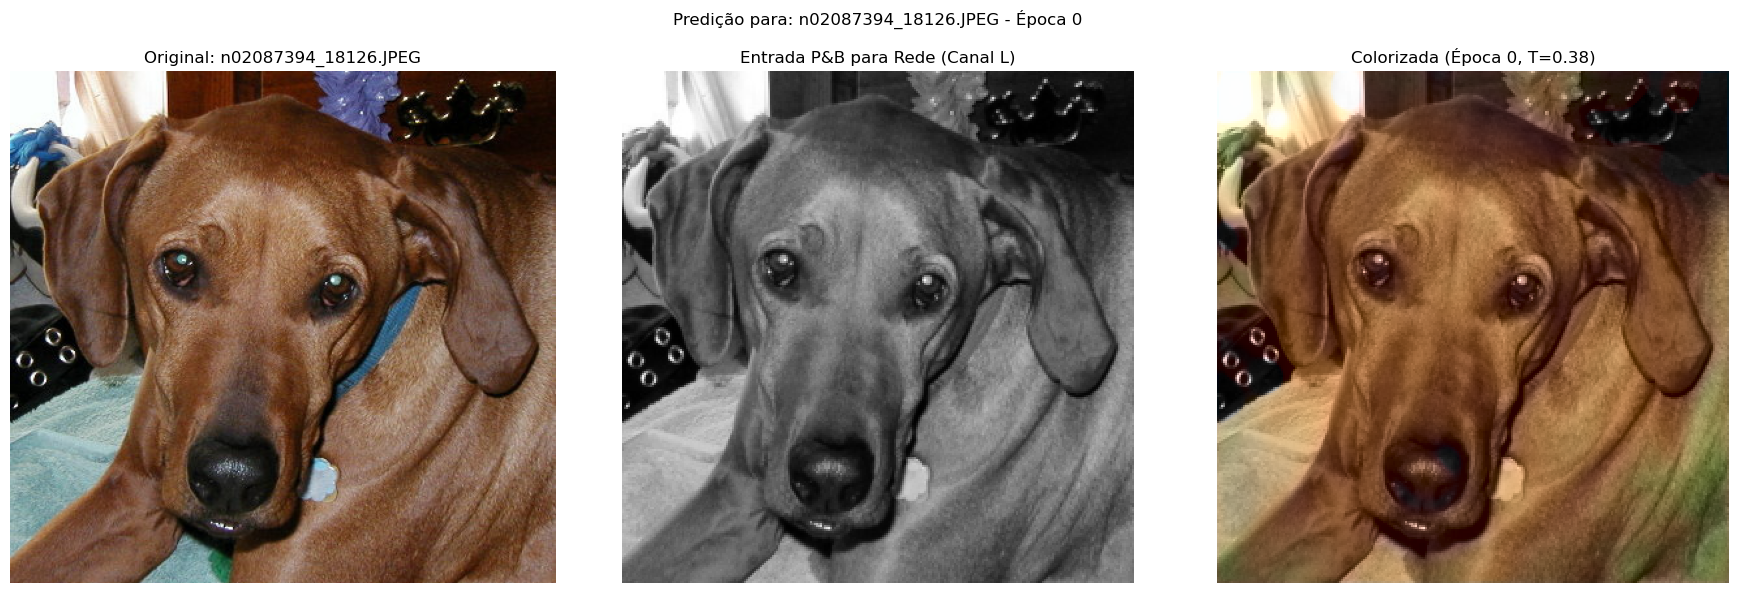

Carregando checkpoint: checkpoints/epoch_0.pt
Realizando predição...


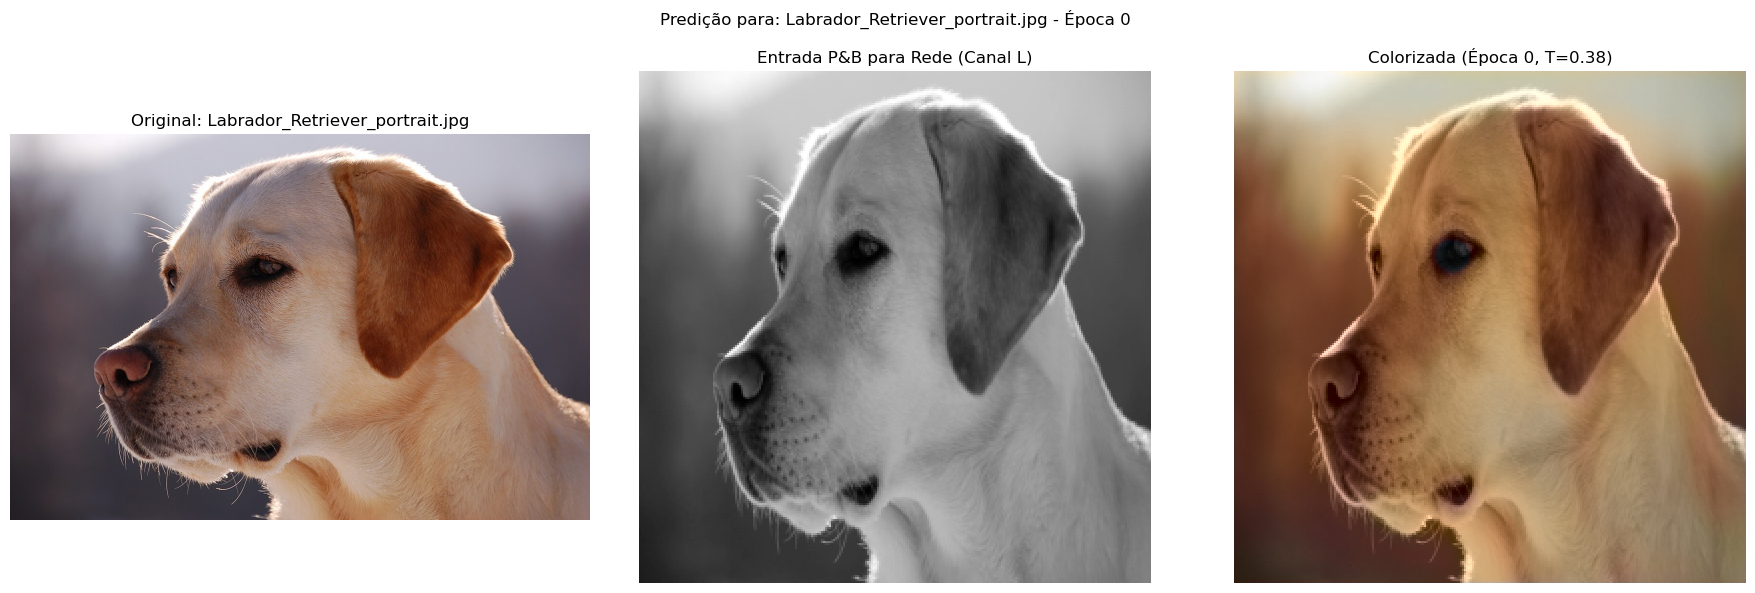

array([[[0.9051385 , 0.8259006 , 0.72981155],
        [0.9005727 , 0.8241439 , 0.70253706],
        [0.8843489 , 0.81855816, 0.70081645],
        ...,
        [0.684611  , 0.63366294, 0.5298591 ],
        [0.6857876 , 0.6295849 , 0.52679735],
        [0.683149  , 0.62492675, 0.5408597 ]],

       [[0.9029528 , 0.82457155, 0.6873773 ],
        [0.8920311 , 0.82299167, 0.68316346],
        [0.873235  , 0.8179164 , 0.6853335 ],
        ...,
        [0.66908765, 0.63922846, 0.5226927 ],
        [0.6698881 , 0.6353503 , 0.51928616],
        [0.67624325, 0.6288558 , 0.52063984]],

       [[0.89714843, 0.82143754, 0.6813145 ],
        [0.8816601 , 0.8207927 , 0.6841115 ],
        [0.8609972 , 0.81604177, 0.6891013 ],
        ...,
        [0.6594025 , 0.64176136, 0.5288891 ],
        [0.6608617 , 0.6378401 , 0.5237869 ],
        [0.6729749 , 0.63509476, 0.52477604]],

       ...,

       [[0.17850757, 0.10766821, 0.06412916],
        [0.17945606, 0.11307772, 0.06921074],
        [0.17741916, 0

In [6]:
def predict_from_epoch_checkpoint(
    image_path,
    epoch_num,
    checkpoint_dir='checkpoints',
    ab_bins_path='data/ab_bins.npy'
):
    """
    Carrega um modelo de um checkpoint de época específico, pré-processa uma imagem RGB,
    e gera a predição de cor, exibindo a original, a P&B (canal L) e a colorizada.

    Args:
        image_path (str): Caminho para a imagem RGB de entrada.
        epoch_num (int): O número da época do checkpoint a ser carregado.
        checkpoint_dir (str): Diretório onde os checkpoints estão salvos.
        ab_bins_path (str): Caminho para o arquivo ab_bins.npy.
    """
    if not os.path.exists(image_path):
        print(f"Erro: Imagem não encontrada em '{image_path}'")
        return None # Adicionado retorno None em caso de erro

    checkpoint_filename = f'epoch_{epoch_num}.pt'
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

    if not os.path.exists(checkpoint_path):
        print(f"Erro: Checkpoint '{checkpoint_path}' não encontrado.")
        return None

    if not os.path.exists(ab_bins_path):
        print(f"Erro: Arquivo de bins AB '{ab_bins_path}' não encontrado. Execute preprocess_colors().")
        return None

    print(f"Carregando checkpoint: {checkpoint_path}")
    try:
        # Certifique-se que DEVICE está definido globalmente ou passe como argumento
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        num_q_bins_loaded = checkpoint['num_q_bins']
        model_state_dict = checkpoint['model_state']
    except Exception as e:
        print(f"Erro ao carregar o checkpoint: {e}")
        return None

    try:
        model = ColorNet(num_q_bins_loaded).to(DEVICE)
        model.load_state_dict(model_state_dict)
        model.eval()
    except Exception as e:
        print(f"Erro ao inicializar ou carregar o estado do modelo: {e}")
        return None

    try:
        ab_bins_for_inference = torch.from_numpy(np.load(ab_bins_path)).float().to(DEVICE)
        if len(ab_bins_for_inference) != num_q_bins_loaded:
            print(f"Aviso Crítico: Incompatibilidade no número de Q bins ({len(ab_bins_for_inference)}) "
                  f"em {ab_bins_path} vs modelo ({num_q_bins_loaded}). Resultados podem ser incorretos.")
    except Exception as e:
        print(f"Erro ao carregar os bins AB: {e}")
        return None

    try:
        img_pil = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Erro ao carregar a imagem de entrada '{image_path}': {e}")
        return None

    original_display_img_pil = img_pil.copy() # Usar para exibição da original
    img_resized_pil = transforms.Resize((IMG_SIZE, IMG_SIZE))(img_pil) # Para entrada no modelo e exibição da P&B

    # Converter para Lab e preparar entrada L
    lab_img_input = color.rgb2lab(np.array(img_resized_pil)).astype(np.float32)
    L_channel_original_scale_resized = lab_img_input[:,:,0] # Escala [0,100], redimensionado
    L_channel_normalized = L_channel_original_scale_resized / 50.0 - 1.0 # Sua normalização
    L_tensor_normalized = torch.FloatTensor(L_channel_normalized).unsqueeze(0).unsqueeze(0).to(DEVICE)

    # Gerar a imagem P&B (canal L) para exibição
    # Para exibir L como imagem P&B, precisamos de um array 2D (H,W) na escala [0,1] ou [0,255]
    # L_channel_original_scale_resized está em [0,100]. Normalizamos para [0,1] dividindo por 100.
    img_l_display = L_channel_original_scale_resized / 100.0
    # Ou, se quiser replicar a imagem que a rede "vê" (normalizada e depois desnormalizada para exibição):
    # img_l_for_display_normalized_range = (L_channel_normalized.cpu().numpy().squeeze() + 1.0) / 2.0 # Mapeia de [-1,1] para [0,1]

    print("Realizando predição...")
    with torch.no_grad():
        predicted_logits = model(L_tensor_normalized)
        temperature = 0.38
        probs_after_temp_anneal = F.softmax(predicted_logits / temperature, dim=1)
        predicted_ab_denormalized = torch.einsum('bqhw,qc->bchw', probs_after_temp_anneal, ab_bins_for_inference)
    
    # Pós-processamento
    # Usar o L_channel_original_scale_resized para reconstruir a imagem Lab colorizada
    L_final_tensor_resized = torch.FloatTensor(L_channel_original_scale_resized).unsqueeze(0).to(predicted_ab_denormalized.device)
    ab_final_tensor = predicted_ab_denormalized.squeeze(0)
    lab_image_reconstructed_tensor = torch.cat([L_final_tensor_resized, ab_final_tensor], dim=0)
    lab_image_reconstructed_np = lab_image_reconstructed_tensor.permute(1,2,0).cpu().numpy()
    
    try:
        rgb_output_final = color.lab2rgb(lab_image_reconstructed_np)
    except Exception as e:
        print(f"Aviso: Conversão Lab->RGB falhou: {e}. Tentando clipar valores Lab.")
        lab_image_reconstructed_np[:,:,1:] = np.clip(lab_image_reconstructed_np[:,:,1:], -128, 127) # Faixa comum de AB
        lab_image_reconstructed_np[:,:,0] = np.clip(lab_image_reconstructed_np[:,:,0], 0, 100)    # Faixa de L
        rgb_output_final = color.lab2rgb(lab_image_reconstructed_np)

    rgb_output_final_clipped = np.clip(rgb_output_final, 0, 1)
    
    # Visualizar
    plt.figure(figsize=(18, 6)) # Aumentado o tamanho da figura para 3 imagens

    plt.subplot(1, 3, 1)
    plt.imshow(original_display_img_pil) # Mostrar a imagem original antes de redimensionar
    plt.title(f'Original: {os.path.basename(image_path)}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    # Para exibir o canal L como P&B, usamos cmap='gray'
    # img_l_display já está na faixa [0,1] se L_channel_original_scale_resized / 100.0
    plt.imshow(img_l_display, cmap='gray')
    plt.title('Entrada P&B para Rede (Canal L)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_output_final_clipped)
    plt.title(f'Colorizada (Época {epoch_num}, T={temperature})')
    plt.axis('off')
    
    plt.suptitle(f"Predição para: {os.path.basename(image_path)} - Época {epoch_num}")
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para o suptitle
    plt.show()

    return rgb_output_final_clipped

predict_from_epoch_checkpoint('data/train/n02087394_18126.JPEG', 0)
predict_from_epoch_checkpoint('/home/renan/Downloads/Labrador_Retriever_portrait.jpg', 0)

In [ ]:
# --- Execução Principal ---
if __name__ == '__main__':
    path_to_training_data = 'data/train'
    os.makedirs(path_to_training_data, exist_ok=True) # Garante que o diretório exista
    # Adicione algumas imagens .jpg, .png, ou .jpeg em 'data/train' para testar.
    # Exemplo: se você tiver uma imagem 'dog.jpg', coloque-a em 'data/train/dog.jpg'.

    print("Verificando necessidade de pré-processamento...")
    preprocess_colors(data_train_path=path_to_training_data, force_recompute=False)

    print("\nIniciando processo de treinamento...")
    latest_chkpt = find_latest_checkpoint()
    num_training_epochs = 50 
    if latest_chkpt:
        print(f"Checkpoint encontrado: {latest_chkpt}. Resumindo treinamento.")
        train(data_path=path_to_training_data, resume_checkpoint=latest_chkpt, num_epochs=num_training_epochs)
    else:
        print("Nenhum checkpoint encontrado. Iniciando novo treinamento.")
        train(data_path=path_to_training_data, num_epochs=num_training_epochs)
    
    print("\nScript concluído.")